# Analiza podatkov z GeoPandas

GeoPandas pozna vse možnosti knjižnice pandas, doda pa ji prostorsko komeponento. V GeoDataFrame lahko preberemo prostorske podatke v datotekah različnih tipov (GeoJSON, Shapefile, ...) in jih v njem hitro in preprosto analiziramo. Še več možnosti pa imamo, če tabelarične podatke pripišemo prostorskim, pri čemer je lahko ključ za povezovanje precej fleksibilen. Python oziroma pandas tu pokažeta vse svoje zmogljivosti.

Pripravimo najprej delovno okolje. Uvozimo knjižnice in nastavimo poti.

In [1]:
# Matplotlib riše v dokument
%matplotlib inline

In [2]:
import json
import contextily as ctx
import geopandas as gpd
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests

from shapely.geometry import box

In [3]:
# Podatki
# data_path = "~/ru-sola/kostir/geo3/"
# Lokalno
data_path = "./data/"

## Združevanje GeoDataFrame 

GeoPandas za združevanje podatkov v GeoDataFrame uporabi za enake ukaze kot pandas. Glavni ukazi so 

* `concat`
* `join`
* `merge`

Združujemo lahko podatke s prostorsko komponento (GeoDataFrame) in podatke brez prostorske geometrije (DataFrame).

### Povezovanje DataFrame

Funkcija `concat()` je osnovna funkcija pandasa za združevanje DataFrame. Podatke lahko združi vzdolž osi (dimenzije), medtem ko na drugih oseh (dimenzijah) izvaja neobvezno nastavljeno logiko (združevanje ali presečišče) indeksov (če obstajajo). Dokumentacija funkcije je v [pandas.concat](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.concat.html).

Začnimo s preprostim primerom združevanje podatkovnih okvirov (brez geometrije).

In [4]:
# Prvi
df1 = pd.DataFrame(
    {'A': ['A0', 'A1', 'A2', 'A3'],
    'B': ['B0', 'B1', 'B2', 'B3'],
    'C': ['C0', 'C1', 'C2', 'C3'],
    'D': ['D0', 'D1', 'D2', 'D3']},
    index=[0, 1, 2, 3])
df1.head()

,A,B,C,D
0,A0,B0,C0,D0
1,A1,B1,C1,D1
2,A2,B2,C2,D2
3,A3,B3,C3,D3


In [5]:
# Drugi
df2 = pd.DataFrame(
    {'A': ['A4', 'A5', 'A6', 'A7'],
    'B': ['B4', 'B5', 'B6', 'B7'],
    'C': ['C4', 'C5', 'C6', 'C7'],
    'D': ['D4', 'D5', 'D6', 'D7']},
    index=[4, 5, 6, 7])
df2.head()

,A,B,C,D
4,A4,B4,C4,D4
5,A5,B5,C5,D5
6,A6,B6,C6,D6
7,A7,B7,C7,D7


In [6]:
# Tretji
df3 = pd.DataFrame(
    {'A': ['A8', 'A9', 'A10', 'A11'],
    'B': ['B8', 'B9', 'B10', 'B11'],
    'C': ['C8', 'C9', 'C10', 'C11'],
    'D': ['D8', 'D9', 'D10', 'D11']},
    index=[8, 9, 10, 11])
df3.head()

,A,B,C,D
8,A8,B8,C8,D8
9,A9,B9,C9,D9
10,A10,B10,C10,D10
11,A11,B11,C11,D11


In [7]:
# Združen
result = pd.concat([df1, df2, df3])
result.head(15)

,A,B,C,D
0,A0,B0,C0,D0
1,A1,B1,C1,D1
2,A2,B2,C2,D2
3,A3,B3,C3,D3
4,A4,B4,C4,D4
5,A5,B5,C5,D5
6,A6,B6,C6,D6
7,A7,B7,C7,D7
8,A8,B8,C8,D8
9,A9,B9,C9,D9


DataFrame si imeli enake stolpce, tudi indeks je sledil. Seveda lahko `concat` podatke združuje zelo zapleteno.

```python
pd.concat(objs, axis=0, join='outer', ignore_index=False, keys=None,
          levels=None, names=None, verify_integrity=False, copy=True)
```

Recimo združuje DataFrame, ki nima enakih stolpcev, niti indeksov.

In [8]:
# Četrti, stolci niso enaki, index prav tako ne
df4 = pd.DataFrame(
    {'B': ['B2', 'B3', 'B6', 'B7'],
    'D': ['D2', 'D3', 'D6', 'D7'],
    'F': ['F2', 'F3', 'F6', 'F7']},
    index=[2, 3, 6, 7])
df4.head()

,B,D,F
2,B2,D2,F2
3,B3,D3,F3
6,B6,D6,F6
7,B7,D7,F7


In [9]:
# Rezultat
result = pd.concat([df1, df4], axis=1, sort=False)
result.head()

,A,B,C,D,B,D,F
0,A0,B0,C0,D0,NaN,NaN,NaN
1,A1,B1,C1,D1,NaN,NaN,NaN
2,A2,B2,C2,D2,B2,D2,F2
3,A3,B3,C3,D3,B3,D3,F3
6,NaN,NaN,NaN,NaN,B6,D6,F6


Podatke, ki jih ni našel v obes DataFrame, je zamenjal z `NaN` (ni podatka).

Lahko pa združimo in obdržimo samo zapise (vrstice), ki imajo podatke v obeh DataFrame.

In [10]:
# Rezultat
result = pd.concat([df1, df4], axis=1, join='inner', sort=False)
result.head()

,A,B,C,D,B,D,F
2,A2,B2,C2,D2,B2,D2,F2
3,A3,B3,C3,D3,B3,D3,F3


### Združevanje DataFrame kot podatkovnih zbirk

pandas ima zmogljivo, vseobsežno, orodje za združevanje, ki je zelo podobno tistemu v relacijskih podatkovnih zbirkah, kot je SQL. pandas deluje hitro, praviloma veliko hitreje kot sorodne rešitve, recimo v jeziku R. Glavni razloga za to je zasnova algoritmov, implementacija in tudi oblika podatkovne strukture DataFrame. Napredne strategije združevanja so opisane v [Pandas Cookbook](https://pandas.pydata.org/pandas-docs/stable/user_guide/cookbook.html#cookbook-merge).

Uporabniki, ki poznajo SQL, ukaze pandas laže osvojijo s primerjavo postopkov v [SQL in pandas](https://pandas.pydata.org/pandas-docs/stable/getting_started/comparison/comparison_with_sql.html#compare-with-sql-join).

Združevanje podatkovnih zbirk DataFrame poteka z:
* `join` in
* `merge`.

`join` je preprostejša. DataFrame ima indeks in `join` združi dve tabeli na osnovi indeksa (indeks je v pandas lahko karkoli). V resnici lahko tudi izberemo stolpec, preko katerega podatke združimo.

Zelo podobna je tudi funkcija `merge`, ki pa ima potrebuje bolj natančna navodila, saj ne združuje po indeksu. V resnici tudi `join` interno uporablja `merge`.  

```python
pd.merge(left, right, how='inner', on=None, left_on=None, right_on=None,
         left_index=False, right_index=False, sort=True,
         suffixes=('_x', '_y'), copy=True, indicator=False,
         validate=None)
```

In [11]:
# Levi DF
left = pd.DataFrame({'key': ['K0', 'K1', 'K2', 'K3'],
                     'A': ['A0', 'A1', 'A2', 'A3'],
                     'B': ['B0', 'B1', 'B2', 'B3']})
left.head()

,key,A,B
0,K0,A0,B0
1,K1,A1,B1
2,K2,A2,B2
3,K3,A3,B3


In [12]:
# Desni DF
right = pd.DataFrame({'key': ['K0', 'K1', 'K2', 'K3'],
                      'C': ['C0', 'C1', 'C2', 'C3'],
                      'D': ['D0', 'D1', 'D2', 'D3']})
right.head()

,key,C,D
0,K0,C0,D0
1,K1,C1,D1
2,K2,C2,D2
3,K3,C3,D3


In [13]:
# Združeni
result = pd.merge(left, right, on='key')
result.head()

,key,A,B,C,D
0,K0,A0,B0,C0,D0
1,K1,A1,B1,C1,D1
2,K2,A2,B2,C2,D2
3,K3,A3,B3,C3,D3


Zadevo lahko precej bolj zakompliciramo in podatke združimo po več ključih. V končni tabeli se pojavijo samo ključi, ki so v obeh (levi in desni) tabelah. Privzeta vrednost je namreč presek, `merge` ima privzeto parameter `how='inner'`.

In [14]:
# Levi
left = pd.DataFrame({'key1': ['K0', 'K0', 'K1', 'K2'],
                     'key2': ['K0', 'K1', 'K0', 'K1'],
                     'A': ['A0', 'A1', 'A2', 'A3'],
                     'B': ['B0', 'B1', 'B2', 'B3']})
left.head()

,key1,key2,A,B
0,K0,K0,A0,B0
1,K0,K1,A1,B1
2,K1,K0,A2,B2
3,K2,K1,A3,B3


In [15]:
# Desni
right = pd.DataFrame({'key1': ['K0', 'K1', 'K1', 'K2'],
                      'key2': ['K0', 'K0', 'K0', 'K0'],
                      'C': ['C0', 'C1', 'C2', 'C3'],
                      'D': ['D0', 'D1', 'D2', 'D3']})
right.head()

,key1,key2,C,D
0,K0,K0,C0,D0
1,K1,K0,C1,D1
2,K1,K0,C2,D2
3,K2,K0,C3,D3


In [16]:
# Združeni
result = pd.merge(left, right, on=['key1', 'key2'])
result.head()

,key1,key2,A,B,C,D
0,K0,K0,A0,B0,C0,D0
1,K1,K0,A2,B2,C1,D1
2,K1,K0,A2,B2,C2,D2


Parameter `how` določi katere ključi se pojavijo v končni tabeli. Če kombinacija ključev ne obstaja v levi ali desni tabeli, je vrednost v tabeli `NaN`. Tule je primerjava združevanja s pandas in SQL.

| pandas merge | SQL Join         | Opis                          |
|:--------------|:------------------|:-------------------------------|
| left         | LEFT OUTER JOIN  | Uporabi samo ključe z leve.   |
| right        | RIGHT OUTER JOIN | Uporabi samo ključe z desne.  |
| outer        | FULL OUTER JOIN  | Unija ključev leve in desne.  |
| inner        | INNER JOIN       | Presek ključev leve in desne. |

## Analiza podatkov o volitvah

Podatki o rezultatih volitev v Sloveniji, ki jih posreduje Republiška volilna komisija, so na voljo v različnih zapisih, med drugim v JSON, XML in Excel. RVK na spletni strani vsakič objavi navodila za dostop. Recimo:

[Novica](https://www.dvk-rs.si/novica/navodila-za-prenos-podatkov-referendum-zv-1g/)

Podatki so v datotekah JSON:

* `udelezba.json` – podatki o udeležbi
* `rezultati.json` – podatki o izidih glasovanja po listah

Datoteke so na spletnih naslovih:

* [Udeležba](volitve.dvk-rs.si/data/udelezba.json)
* [Rezultati](volitve.dvk-rs.si/data/rezultati.json)

Vsebina datotek je dobro opisana:
[Državna volilna komisija](https://www.dvk-rs.si/)

Uporabimo JSON in preberimo podatke v DataFrame. JSON je kot smo že pokazali precej zapletena struktura.

In [17]:
# # Volitve v Sloveniji, rezultati na spletu
# vol_udelezba = 'https://volitve.dvk-rs.si/data/udelezba.json'
# vol_rezultati = 'https://volitve.dvk-rs.si/data/rezultati.json'

Volilna komisija podatke umakne, zato jih bomo prenesli iz GitHuba in shranili lokalno.

In [18]:
# Rezlutati na GitHubu
vol_udelezba = 'https://raw.githubusercontent.com/stefanb/dvk-volitve-ep2024/refs/heads/main/data/ep2024/udelezba.json'
vol_rezultati = 'https://raw.githubusercontent.com/stefanb/dvk-volitve-ep2024/refs/heads/main/data/ep2024/rezultati.json'

In [19]:
# Imena datoteka
vol_udelezba_json_fn = "vol_udelezba.json"

In [20]:
# Preberemo JSON datoteko s spleta
r = requests.get(vol_udelezba)
vol_udelezba_json = json.loads(r.content)

In [21]:
# Prebremo JSON v DataFrame, zanima nas del o volilnih enotah
vol_udelezba_df = pd.DataFrame(vol_udelezba_json["enote"])
vol_udelezba_df = vol_udelezba_df.drop(['okraji'], axis=1)
vol_udelezba_df

,st,rpeid,naz,upr,gl,prc
0,1,1000,VE 1000 - KRANJ,208092,93602,0.4498
1,2,2000,VE 2000 - POSTOJNA,208571,84946,0.4073
2,3,3000,VE 3000 - LJUBLJANA CENTER,220028,102427,0.4655
3,4,4000,VE 4000 - LJUBLJANA BEŽIGRAD,208634,91658,0.4393
4,5,5000,VE 5000 - CELJE,210446,85275,0.4052
5,6,6000,VE 6000 - NOVO MESTO,217462,86169,0.3962
6,7,7000,VE 7000 - MARIBOR,206670,77962,0.3772
7,8,8000,VE 8000 - PTUJ,209677,77010,0.3673


Preberemo tudi podatke o volilnih enotah in okrajih, ki so v GeoJSON obliki.

In [22]:
# Ime datoteke - volilne enote in volilni okraji
geo_enote = data_path + "volilne_enote.geojson"
geo_okraji = data_path + "volilni_okraji.geojson"

In [23]:
# Preberemo GeoJSON z volilnimi enotami
geo_enote_gdf = gpd.read_file(geo_enote)

In [24]:
# Enote izpišemo
geo_enote_gdf

,ENOTA,VDV_MID,VDV_ID,VDV_UIME,VDV_DJ,POV_KM2,D_OD,DV_OD,N8,C1,STATUS,Y_C,X_C,geometry
0,VE,10858097,3,Volilna enota 3,None,1529.82,1995-01-01,1995-01-01,None,None,V,462070,101030,"MULTIPOLYGON (((14.6005 45.91087, 14.6009 45.9..."
1,VE,10858062,2,Volilna enota 2,None,3916.78,1995-01-01,1995-01-01,None,None,V,402730,116510,"MULTIPOLYGON (((13.64635 45.53319, 13.64652 45..."
2,VE,10858135,5,Volilna enota 5,None,2551.09,1995-01-01,1995-01-01,None,None,V,497626,155521,"MULTIPOLYGON (((15.16015 46.65707, 15.16078 46..."
3,VE,10858127,4,Volilna enota 4,None,2209.54,1995-01-01,1995-01-01,None,None,V,469600,111380,"MULTIPOLYGON (((14.5968 45.91305, 14.59671 45...."
4,VE,10858160,8,Volilna enota 8,None,2571.35,1995-01-01,1995-01-01,None,None,V,576310,170620,"MULTIPOLYGON (((16.27437 46.87228, 16.27478 46..."
5,VE,10858054,1,Volilna enota 1,None,2851.59,1995-01-01,1995-01-01,None,None,V,428150,144040,"MULTIPOLYGON (((13.90792 46.51976, 13.90813 46..."
6,VE,10858151,7,Volilna enota 7,None,1558.52,1995-01-01,1995-01-01,None,None,V,549740,157810,"MULTIPOLYGON (((15.43845 46.64038, 15.43858 46..."
7,VE,10858143,6,Volilna enota 6,None,3082.17,1995-01-01,1995-01-01,None,None,V,504160,111730,"MULTIPOLYGON (((14.87074 45.85581, 14.87143 45..."


Rezultate volitev v navadnem DataFrame združimo s podatki volilnih enot v GeoDataFrame.

Nato rezultat prikažimo v obliki karte, dodamo tudi ozadje.

In [25]:
# Združimo GeoDataFrame volilnih enot in rezultatov
vol_udelezba_gdf = pd.merge(geo_enote_gdf, vol_udelezba_df, left_on='VDV_ID', right_on='st')
vol_udelezba_gdf

,ENOTA,VDV_MID,VDV_ID,VDV_UIME,VDV_DJ,POV_KM2,D_OD,DV_OD,N8,C1,STATUS,Y_C,X_C,geometry,st,rpeid,naz,upr,gl,prc
0,VE,10858097,3,Volilna enota 3,None,1529.82,1995-01-01,1995-01-01,None,None,V,462070,101030,"MULTIPOLYGON (((14.6005 45.91087, 14.6009 45.9...",3,3000,VE 3000 - LJUBLJANA CENTER,220028,102427,0.4655
1,VE,10858062,2,Volilna enota 2,None,3916.78,1995-01-01,1995-01-01,None,None,V,402730,116510,"MULTIPOLYGON (((13.64635 45.53319, 13.64652 45...",2,2000,VE 2000 - POSTOJNA,208571,84946,0.4073
2,VE,10858135,5,Volilna enota 5,None,2551.09,1995-01-01,1995-01-01,None,None,V,497626,155521,"MULTIPOLYGON (((15.16015 46.65707, 15.16078 46...",5,5000,VE 5000 - CELJE,210446,85275,0.4052
3,VE,10858127,4,Volilna enota 4,None,2209.54,1995-01-01,1995-01-01,None,None,V,469600,111380,"MULTIPOLYGON (((14.5968 45.91305, 14.59671 45....",4,4000,VE 4000 - LJUBLJANA BEŽIGRAD,208634,91658,0.4393
4,VE,10858160,8,Volilna enota 8,None,2571.35,1995-01-01,1995-01-01,None,None,V,576310,170620,"MULTIPOLYGON (((16.27437 46.87228, 16.27478 46...",8,8000,VE 8000 - PTUJ,209677,77010,0.3673
5,VE,10858054,1,Volilna enota 1,None,2851.59,1995-01-01,1995-01-01,None,None,V,428150,144040,"MULTIPOLYGON (((13.90792 46.51976, 13.90813 46...",1,1000,VE 1000 - KRANJ,208092,93602,0.4498
6,VE,10858151,7,Volilna enota 7,None,1558.52,1995-01-01,1995-01-01,None,None,V,549740,157810,"MULTIPOLYGON (((15.43845 46.64038, 15.43858 46...",7,7000,VE 7000 - MARIBOR,206670,77962,0.3772
7,VE,10858143,6,Volilna enota 6,None,3082.17,1995-01-01,1995-01-01,None,None,V,504160,111730,"MULTIPOLYGON (((14.87074 45.85581, 14.87143 45...",6,6000,VE 6000 - NOVO MESTO,217462,86169,0.3962


<Axes: >

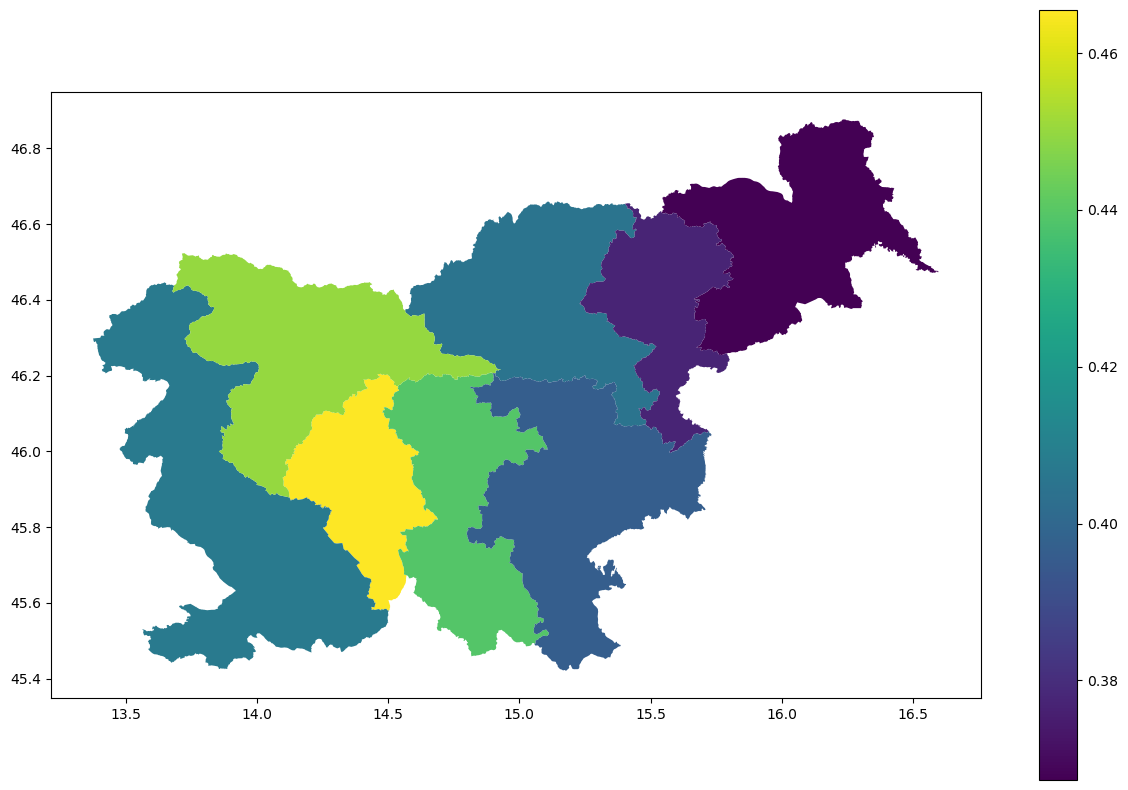

In [26]:
# Prikaz
vol_udelezba_gdf.plot(figsize=(15,10), column = "prc", legend=True)

In [27]:
# Preprojekcija
vol_udelezba_gdf_we = vol_udelezba_gdf.to_crs(epsg='3857')

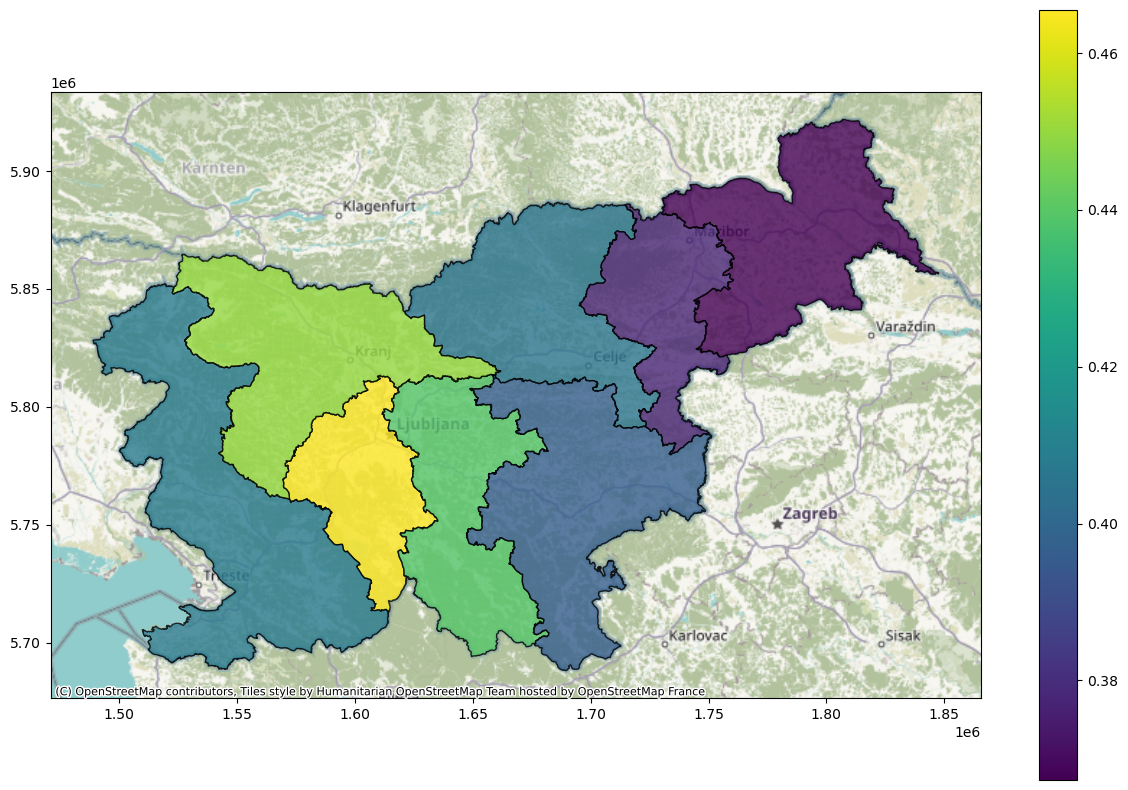

In [28]:
# Prikaz
ax = vol_udelezba_gdf_we.plot(figsize=(15,10), alpha=0.8, edgecolor='k', column = "prc", legend=True)
ctx.add_basemap(ax)

### Uporaba RPE

Podatki o volilnih okrajih in enotah so tudi v RPE. Preberimo sloj RPE in prikažimo.

[RPE Struktura](https://www.e-prostor.gov.si/fileadmin/struktura/RPE_struktura.pdf)
[RPE Šifrant](https://www.e-prostor.gov.si/fileadmin/struktura/sifrant_rpe_enot.htm)

Na koncu združimo sloj RPE in rezultate volitev. 

In [29]:
# Ime datoteke - volilni okraji za državnozborske volitve
meja_fn = "zip://" + data_path + "DRZAVNA_MEJA.zip"
# Ime datoteke - RPE volilni okraji in enote
vdv_fn = "zip://" + data_path + "RPE_PE_D96.zip/VDV/VDV.shp"

In [30]:
# Podatki o meji
slo_meja_gdf = gpd.read_file(meja_fn)
slo_meja_gdf.head()

,Id,Drzava,OCENA_NAT,geometry
0,241,SLO-HRV,do 4 cm,"LINESTRING Z (384658.9 42356.03 0, 379119.32 4..."
1,240,SLO-HRV,do 1 m,"LINESTRING Z (389423.1 38583.31 0, 384658.9 42..."
2,239,SLO-HRV,do 1 m,"LINESTRING Z (394542.83 35777.15 0, 394536.29 ..."
3,238,SLO-HRV,do 1 m,"LINESTRING Z (394537.99 35766.1 0, 394542.83 3..."
4,237,SLO-HRV,do 1 m,"LINESTRING Z (394753.77 35609.86 0, 394753.69 ..."


In [31]:
# Podatki o volilnih okrajih in enotah
slo_vdv_gdf = gpd.read_file(vdv_fn, encoding="windows-1250")
len(slo_vdv_gdf)

3104

In [32]:
# Izberemo samo volilne enote
slo_vdv_gdf_en = slo_vdv_gdf[slo_vdv_gdf['ENOTA'] == 'VE']
len(slo_vdv_gdf_en)

8

In [33]:
# Združimo GeoDataFrame volilnih enot in rezultatov
slo_vdv_udelezba_gdf = pd.merge(slo_vdv_gdf_en, vol_udelezba_df, left_on='VDV_ID', right_on='st')
slo_vdv_udelezba_gdf

,ENOTA,VDV_MID,VDV_ID,VDV_UIME,VDV_DJ,POV_KM2,D_OD,DV_OD,N8,C1,STATUS,CEN_E,CEN_N,geometry,st,rpeid,naz,upr,gl,prc
0,VE,10858097,3,Volilna enota 3,NaN,1530.03,1995-01-01,1995-01-01,NaN,None,V,461699.0,101516.0,"POLYGON ((460048.23 108606.581, 460075.229 108...",3,3000,VE 3000 - LJUBLJANA CENTER,220028,102427,0.4655
1,VE,10858143,6,Volilna enota 6,NaN,3081.94,1995-01-01,1995-01-01,NaN,None,V,503790.0,112215.0,"POLYGON ((506723.774 96862.887, 506739.461 968...",6,6000,VE 6000 - NOVO MESTO,217462,86169,0.3962
2,VE,10858160,8,Volilna enota 8,NaN,2571.22,1995-01-01,1995-01-01,NaN,None,V,575942.0,171103.0,"POLYGON ((597149.96 193320.257, 597181.46 1933...",8,8000,VE 8000 - PTUJ,209677,77010,0.3673
3,VE,10858151,7,Volilna enota 7,NaN,1558.30,1995-01-01,1995-01-01,NaN,None,V,549372.0,158294.0,"POLYGON ((535932.762 163798.038, 535976.763 16...",7,7000,VE 7000 - MARIBOR,206670,77962,0.3772
4,VE,10858127,4,Volilna enota 4,NaN,2209.75,1995-01-01,1995-01-01,NaN,None,V,469229.0,111866.0,"POLYGON ((460177.231 108632.579, 460222.232 10...",4,4000,VE 4000 - LJUBLJANA BEŽIGRAD,208634,91658,0.4393
5,VE,10858135,5,Volilna enota 5,NaN,2551.71,1995-01-01,1995-01-01,NaN,None,V,497257.0,156007.0,"POLYGON ((509086.494 168254.43, 509113.377 168...",5,5000,VE 5000 - CELJE,210446,85275,0.4052
6,VE,10858062,2,Volilna enota 2,NaN,3916.73,1995-01-01,1995-01-01,NaN,None,V,402358.0,116998.0,"POLYGON ((394273.002 44593.853, 394286.002 446...",2,2000,VE 2000 - POSTOJNA,208571,84946,0.4073
7,VE,10858054,1,Volilna enota 1,NaN,2851.55,1995-01-01,1995-01-01,NaN,None,V,427780.0,144528.0,"POLYGON ((406688.113 153093.515, 406844.115 15...",1,1000,VE 1000 - KRANJ,208092,93602,0.4498


<Axes: >

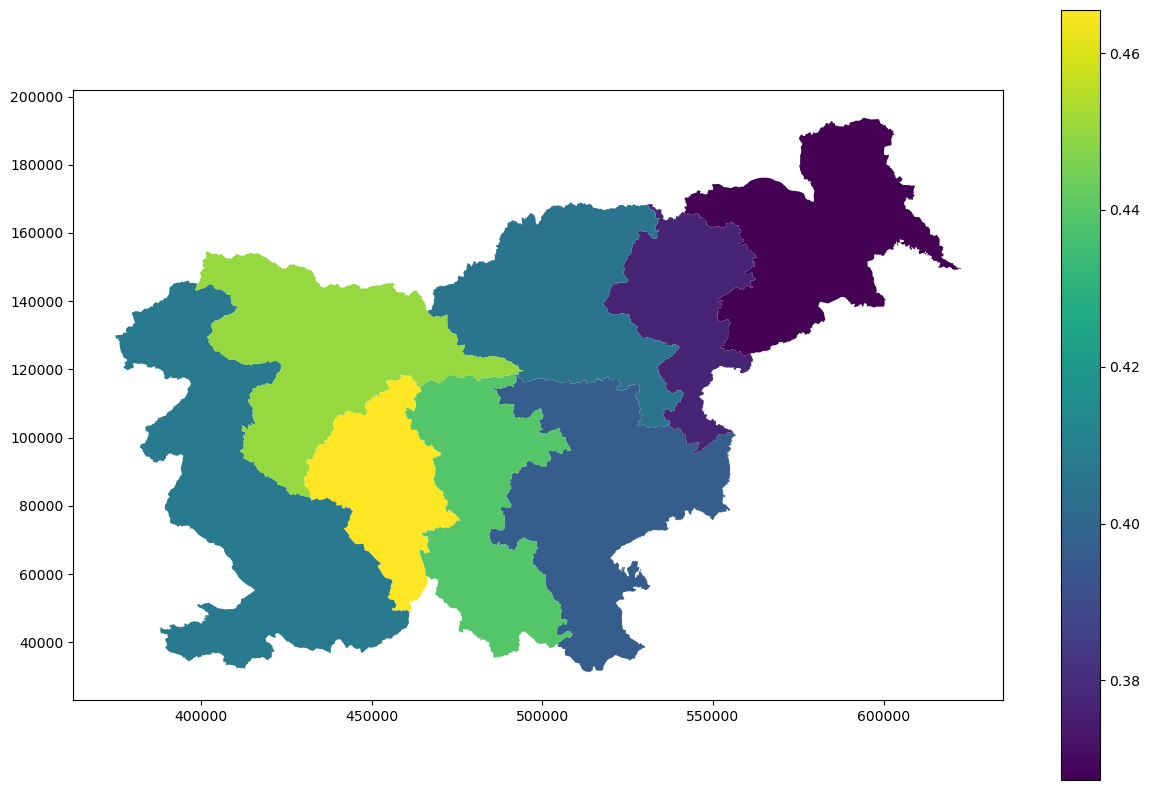

In [34]:
# Prikažemo podatke o volilni udeležbi po volilnih enotah
slo_vdv_udelezba_gdf.plot(figsize=(15,10), column = "prc", legend=True)

### Po okrajih

Naredimo še analizo po volilnih okrajih.

JSON datoteka je hierarhična. Podatki za volilne okraje so v podatkih za volilno enoto. JSON je potrebno zato normalizirati.

In [35]:
# JSON je potrebno normalizirati, vsak okraj ima svoje enote v JSON obliki
vol_udelezba_ok_df = pd.json_normalize(vol_udelezba_json["enote"], record_path='okraji', meta=['st', 'naz','upr', 'gl', 'prc'],record_prefix='vo_')
vol_udelezba_ok_df.head()

,vo_st,vo_rpeid,vo_naz,vo_upr,vo_gl,vo_prc,st,naz,upr,gl,prc
0,1,1001,VO 1001 - JESENICE,25955,9170,0.3533,1,VE 1000 - KRANJ,208092,93602,0.4498
1,2,1002,VO 1002 - RADOVLJICA 1,13412,6318,0.4711,1,VE 1000 - KRANJ,208092,93602,0.4498
2,3,1003,VO 1003 - RADOVLJICA 2,15875,7214,0.4544,1,VE 1000 - KRANJ,208092,93602,0.4498
3,4,1004,VO 1004 - KRANJ 1,20255,8638,0.4265,1,VE 1000 - KRANJ,208092,93602,0.4498
4,5,1005,VO 1005 - KRANJ 2,20322,8850,0.4355,1,VE 1000 - KRANJ,208092,93602,0.4498


In [36]:
# Dodatmo enolični ID okraja, ki je enak kot v RPE
vol_udelezba_ok_df['vdv_id'] = 1000 * vol_udelezba_ok_df['st'] + vol_udelezba_ok_df['vo_st']
vol_udelezba_ok_df.head()

,vo_st,vo_rpeid,vo_naz,vo_upr,vo_gl,vo_prc,st,naz,upr,gl,prc,vdv_id
0,1,1001,VO 1001 - JESENICE,25955,9170,0.3533,1,VE 1000 - KRANJ,208092,93602,0.4498,1001
1,2,1002,VO 1002 - RADOVLJICA 1,13412,6318,0.4711,1,VE 1000 - KRANJ,208092,93602,0.4498,1002
2,3,1003,VO 1003 - RADOVLJICA 2,15875,7214,0.4544,1,VE 1000 - KRANJ,208092,93602,0.4498,1003
3,4,1004,VO 1004 - KRANJ 1,20255,8638,0.4265,1,VE 1000 - KRANJ,208092,93602,0.4498,1004
4,5,1005,VO 1005 - KRANJ 2,20322,8850,0.4355,1,VE 1000 - KRANJ,208092,93602,0.4498,1005


In [37]:
len(vol_udelezba_ok_df)

88

In [38]:
# Iz RPE izločimo samo okraje
slo_vdv_ok_gdf = slo_vdv_gdf[slo_vdv_gdf['ENOTA'] == "VO"].copy()
slo_vdv_ok_gdf.head()

,ENOTA,VDV_MID,VDV_ID,VDV_UIME,VDV_DJ,POV_KM2,D_OD,DV_OD,N8,C1,STATUS,CEN_E,CEN_N,geometry
8,VO,10858186,1001,Ve 1 - 1. volilni okraj,NaN,374.88,1995-01-01,1995-01-01,NaN,None,V,427780.0,144528.0,"POLYGON ((416209.419 153932.359, 416225.42 153..."
9,VO,10858194,1002,Ve 1 - 2. Volilni okraj,NaN,509.77,1995-01-01,1995-01-01,NaN,None,V,421729.0,142828.0,"POLYGON ((408416.333 122753.324, 408396.453 12..."
10,VO,10858208,1003,Ve 1 - 3. Volilni okraj,NaN,131.20,1995-01-01,1995-01-01,NaN,None,V,436269.0,133978.0,"POLYGON ((443190.895 131659.757, 443191.835 13..."
11,VO,10858216,1004,Ve 1 - 4. Volilni okraj,NaN,29.64,1995-01-01,1995-01-01,NaN,None,V,450319.0,122857.0,"POLYGON ((449924.532 128403.101, 449934.603 12..."
12,VO,10858224,1005,Ve 1 - 5. Volilni okraj,NaN,86.72,1995-01-01,1995-01-01,NaN,None,V,441569.0,125717.0,"POLYGON ((450215.5 124009.038, 450218.499 1239..."


In [39]:
len(slo_vdv_ok_gdf)

88

In [40]:
# Združimo z rezultati volitev
slo_vdv_ok_udelezba_gdf = pd.merge(slo_vdv_ok_gdf, vol_udelezba_ok_df, left_on='VDV_ID', right_on='vdv_id')
slo_vdv_ok_udelezba_gdf.head()

,ENOTA,VDV_MID,VDV_ID,VDV_UIME,VDV_DJ,POV_KM2,D_OD,DV_OD,N8,C1,...,vo_naz,vo_upr,vo_gl,vo_prc,st,naz,upr,gl,prc,vdv_id
0,VO,10858186,1001,Ve 1 - 1. volilni okraj,NaN,374.88,1995-01-01,1995-01-01,NaN,None,...,VO 1001 - JESENICE,25955,9170,0.3533,1,VE 1000 - KRANJ,208092,93602,0.4498,1001
1,VO,10858194,1002,Ve 1 - 2. Volilni okraj,NaN,509.77,1995-01-01,1995-01-01,NaN,None,...,VO 1002 - RADOVLJICA 1,13412,6318,0.4711,1,VE 1000 - KRANJ,208092,93602,0.4498,1002
2,VO,10858208,1003,Ve 1 - 3. Volilni okraj,NaN,131.20,1995-01-01,1995-01-01,NaN,None,...,VO 1003 - RADOVLJICA 2,15875,7214,0.4544,1,VE 1000 - KRANJ,208092,93602,0.4498,1003
3,VO,10858216,1004,Ve 1 - 4. Volilni okraj,NaN,29.64,1995-01-01,1995-01-01,NaN,None,...,VO 1004 - KRANJ 1,20255,8638,0.4265,1,VE 1000 - KRANJ,208092,93602,0.4498,1004
4,VO,10858224,1005,Ve 1 - 5. Volilni okraj,NaN,86.72,1995-01-01,1995-01-01,NaN,None,...,VO 1005 - KRANJ 2,20322,8850,0.4355,1,VE 1000 - KRANJ,208092,93602,0.4498,1005


In [41]:
len(slo_vdv_ok_udelezba_gdf)

88

In [42]:
# Iračunamo odstotke
slo_vdv_ok_udelezba_gdf['vo_ods'] = 100 * slo_vdv_ok_udelezba_gdf['vo_prc']

<Axes: >

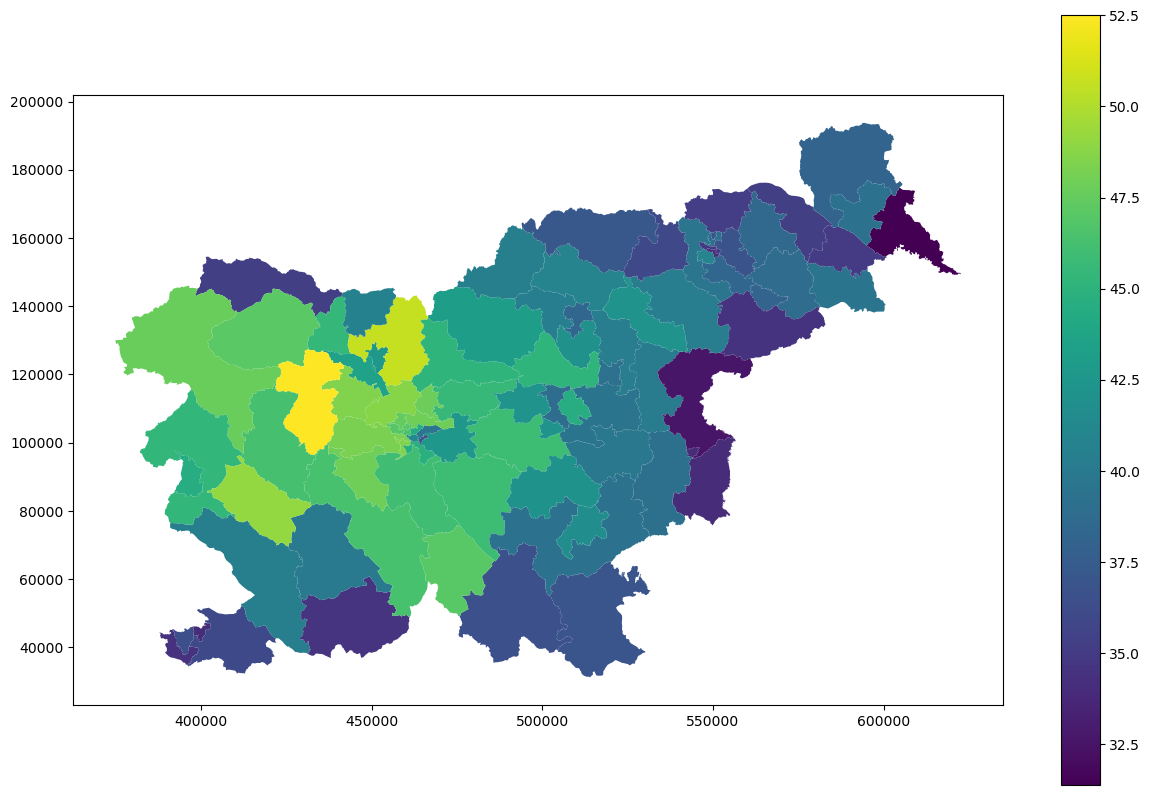

In [43]:
# Prikažemo rezultat
slo_vdv_ok_udelezba_gdf.plot(figsize=(15,10), column = "vo_ods", legend=True)

<Axes: >

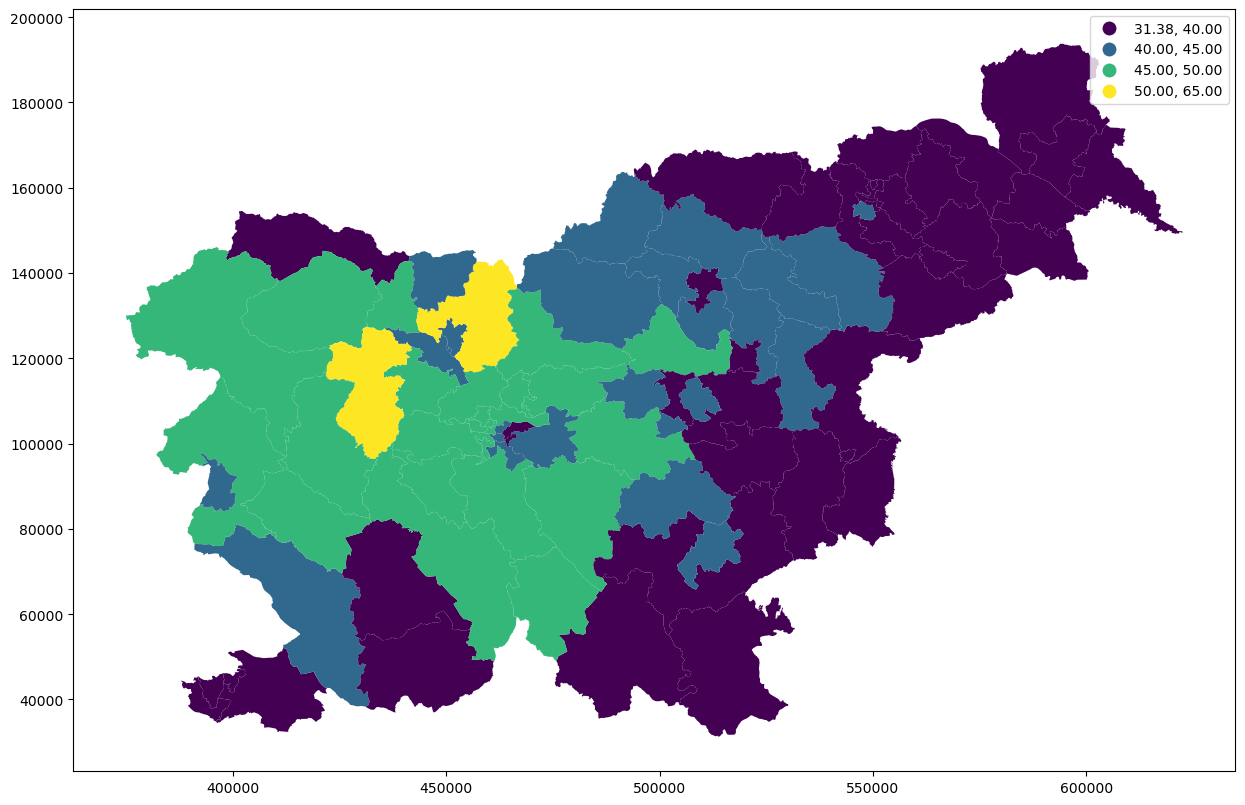

In [44]:
# Podatke klasificramo v razrede
slo_vdv_ok_udelezba_gdf.plot(figsize=(15,10), column = "vo_ods", legend=True, scheme="User_Defined", 
         classification_kwds=dict(bins=[40, 45, 50, 65]))

## Podatki Our World in Data

Spletna stran Our World in Data ponuja obsežne podatke o različnih svetovnih problemih. Podatki so zbrani iz različnih virov in so na voljo v obliki, ki omogoča enostavno analizo in vizualizacijo.

Podatki na spletni strani [Our World in Data](https://ourworldindata.org/).

Najboljši primeri OWID za uporabo (z jasnim pripovedovanjem zgodb):

* Emisije CO₂ na prebivalca v primerjavi s skupnimi emisijami (odlično za prikazovanje pravičnosti + obsega)
* Pričakovana življenjska doba skozi čas (preprost, močan primer dolgoročnega napredka)
* Zmanjšanje otroške umrljivosti (zelo močan primer „napredka + vpliva politike“)
* Prehod na druge vire energije (premog → obnovljivi viri energije) (odličen primer za pripovedovanje zgodb o podnebju/energiji)
* Globalni trendi prihodkov/revščine (primeren za razprave o neenakosti + razvoju)

pandas jih lahko prebere neposredno iz spleta.

### Emisije CO₂ na prebivalca

In [45]:
# OWID Grapher CSV končna točka za ta indikator
# (Entity, Code, Year, Value)
url = "https://ourworldindata.org/grapher/co-emissions-per-capita.csv"
df = pd.read_csv(
    url,
    storage_options={"User-Agent": "Mozilla/5.0"}
)
df.head()

,Entity,Code,Year,CO₂ emissions per capita
0,Afghanistan,AFG,1949,0.001992
1,Afghanistan,AFG,1950,0.010837
2,Afghanistan,AFG,1951,0.011625
3,Afghanistan,AFG,1952,0.011468
4,Afghanistan,AFG,1953,0.013123


In [46]:
# Izberite leto (najnovejše, ki je na voljo v podatkovni zbirki)
year = int(df["Year"].max())
d = df[df["Year"] == year].copy()
d.head()

,Entity,Code,Year,CO₂ emissions per capita
75,Afghanistan,AFG,2024,0.253848
216,Africa,NaN,2024,0.992568
308,Albania,ALB,2024,1.591990
417,Algeria,DZA,2024,4.233817
452,Andorra,AND,2024,5.181661


In [47]:
# Ohranite samo vrstice z ISO3 kodami držav (izločite agregate, kot so "World", "Europe" itd.).
d = d[d["Code"].str.len().eq(3)]

In [48]:
# Preberi podatke o svetu
url = "https://naturalearth.s3.amazonaws.com/110m_cultural/ne_110m_admin_0_countries.zip"
world = gpd.read_file(url)
world.head()

,featurecla,scalerank,LABELRANK,SOVEREIGNT,SOV_A3,ADM0_DIF,LEVEL,TYPE,TLC,ADMIN,...,FCLASS_TR,FCLASS_ID,FCLASS_PL,FCLASS_GR,FCLASS_IT,FCLASS_NL,FCLASS_SE,FCLASS_BD,FCLASS_UA,geometry
0,Admin-0 country,1,6,Fiji,FJI,0,2,Sovereign country,1,Fiji,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"MULTIPOLYGON (((180 -16.06713, 180 -16.55522, ..."
1,Admin-0 country,1,3,United Republic of Tanzania,TZA,0,2,Sovereign country,1,United Republic of Tanzania,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"POLYGON ((33.90371 -0.95, 34.07262 -1.05982, 3..."
2,Admin-0 country,1,7,Western Sahara,SAH,0,2,Indeterminate,1,Western Sahara,...,Unrecognized,Unrecognized,Unrecognized,NaN,NaN,Unrecognized,NaN,NaN,NaN,"POLYGON ((-8.66559 27.65643, -8.66512 27.58948..."
3,Admin-0 country,1,2,Canada,CAN,0,2,Sovereign country,1,Canada,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"MULTIPOLYGON (((-122.84 49, -122.97421 49.0025..."
4,Admin-0 country,1,2,United States of America,US1,1,2,Country,1,United States of America,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"MULTIPOLYGON (((-122.84 49, -120 49, -117.0312..."


In [49]:
# Združi podatke o svetu in emisijah CO₂
world_co2 = world.merge(d, left_on="ISO_A3", right_on="Code")
world_co2.head()

,featurecla,scalerank,LABELRANK,SOVEREIGNT,SOV_A3,ADM0_DIF,LEVEL,TYPE,TLC,ADMIN,...,FCLASS_IT,FCLASS_NL,FCLASS_SE,FCLASS_BD,FCLASS_UA,geometry,Entity,Code,Year,CO₂ emissions per capita
0,Admin-0 country,1,6,Fiji,FJI,0,2,Sovereign country,1,Fiji,...,NaN,NaN,NaN,NaN,NaN,"MULTIPOLYGON (((180 -16.06713, 180 -16.55522, ...",Fiji,FJI,2024,1.556111
1,Admin-0 country,1,3,United Republic of Tanzania,TZA,0,2,Sovereign country,1,United Republic of Tanzania,...,NaN,NaN,NaN,NaN,NaN,"POLYGON ((33.90371 -0.95, 34.07262 -1.05982, 3...",Tanzania,TZA,2024,0.291982
2,Admin-0 country,1,2,Canada,CAN,0,2,Sovereign country,1,Canada,...,NaN,NaN,NaN,NaN,NaN,"MULTIPOLYGON (((-122.84 49, -122.97421 49.0025...",Canada,CAN,2024,13.419917
3,Admin-0 country,1,2,United States of America,US1,1,2,Country,1,United States of America,...,NaN,NaN,NaN,NaN,NaN,"MULTIPOLYGON (((-122.84 49, -120 49, -117.0312...",United States,USA,2024,14.197287
4,Admin-0 country,1,3,Kazakhstan,KA1,1,1,Sovereignty,1,Kazakhstan,...,NaN,NaN,NaN,NaN,NaN,"POLYGON ((87.35997 49.21498, 86.59878 48.54918...",Kazakhstan,KAZ,2024,13.937352


In [50]:
# Stolpci v world_co2
world_co2.columns

Index(['featurecla', 'scalerank', 'LABELRANK', 'SOVEREIGNT', 'SOV_A3',
       'ADM0_DIF', 'LEVEL', 'TYPE', 'TLC', 'ADMIN',
       ...
       'FCLASS_IT', 'FCLASS_NL', 'FCLASS_SE', 'FCLASS_BD', 'FCLASS_UA',
       'geometry', 'Entity', 'Code', 'Year', 'CO₂ emissions per capita'],
      dtype='str', length=173)

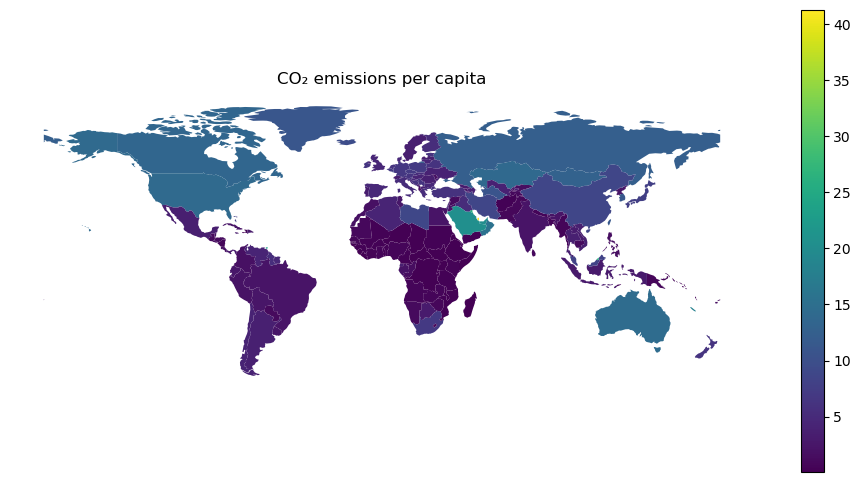

In [51]:
# Naredi zemljevid sveta
ax = world_co2.plot(
    column="CO₂ emissions per capita",   # <- your data column
    cmap="viridis",
    legend=True,
    figsize=(12, 6),
    missing_kwds={"color": "lightgrey", "label": "No data"},
)
ax.set_axis_off()
ax.set_title("CO₂ emissions per capita")
plt.show()

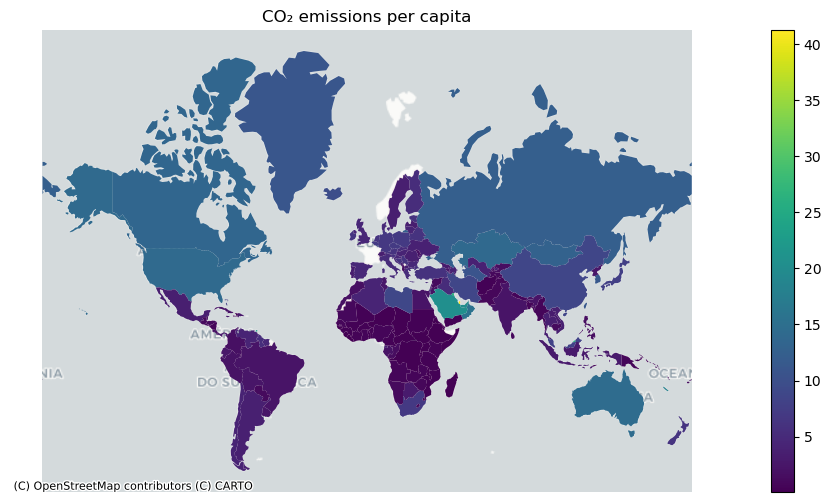

In [52]:
# Lepa karta
g = world_co2.to_crs(epsg=3857)

ax = g.plot(
    column="CO₂ emissions per capita",
    cmap="viridis",
    legend=True,
    figsize=(12, 6),
    missing_kwds={"color": "lightgrey", "label": "No data"},
)

ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)
ax.set_axis_off()
ax.set_title("CO₂ emissions per capita")
plt.show()

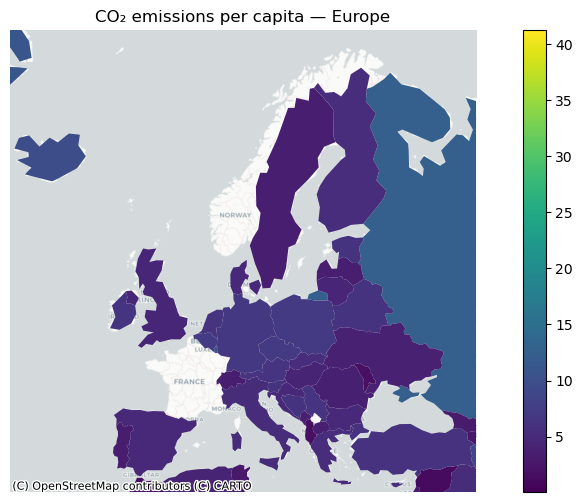

In [53]:
# Evropa
g = world_co2.to_crs(epsg=3857)

# Europe bbox in lon/lat, then reproject to 3857
europe_bbox = gpd.GeoSeries(
    [box(-25, 34, 45, 72)], crs=4326
).to_crs(epsg=3857)

xmin, ymin, xmax, ymax = europe_bbox.total_bounds

ax = g.plot(
    column="CO₂ emissions per capita",
    cmap="viridis",
    legend=True,
    figsize=(12, 6),
    missing_kwds={"color": "lightgrey", "label": "No data"},
)

ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)

ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)
ax.set_axis_off()
ax.set_title("CO₂ emissions per capita — Europe")
plt.show()